# Course assessment 
## Numerical processing of financial data MAP542 

Stefano De Marco

#### Objective
The goal of this project is to fit some implied volatility parametrisations to market option data while studying their no-arbitrage properties.

- Please write commented code. You can also use text cells for your comments and explanations.
- The code must follow the good coding principles (it must be clean, readable, etc.). 
- Graphs must have a title, a legend and their axes must be labeled. 
- At the end, submit your notebooks and a pdf file of 5 to 8 pages into the Moodle Assignment you will find in "Assessment part II". In the pdf file, you are asked to explain the procedure you have followed to complete the given tasks, and present/discuss your results (being they positive or negative).

#### Modules

Feel free to add any other (open-source) module you need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. The SVI parameterisation for the implied volatility

### Part 1.1 

$\blacktriangleright$ __TO DO__: Complete and submit the notebook "Notebook_9_no_arbitrage_implied_vol.ipynb"

### Part 1.2

$\blacktriangleright$ __New dataset__ : you can download delayed option quotes on the SP500 index from the [CBOE quotes platform](http://www.cboe.com/delayedquote/quote-table) (index symbol: SPX). 
 
$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the standard maturities for SPX options being the third Friday of each month), filter out quotes that have zero volume, and perform a fitting (learning) of the SVI model parameters as done in Notebook 9. 
If you wish to use yet another set of option prices (e.g. on another asset), this is also possible. In any case, provide the dataset together with your notebook.

$\blacktriangleright$ Try to take into account the no-arbitrage conditions within the parameter learning process (or at least, after the learning process).

Explain in details the procedure you have followed, and present/discuss your results.

$\blacktriangleright$ __New dataset__ : you can download delayed option quotes on the SP500 index from the [CBOE quotes platform](http://www.cboe.com/delayedquote/quote-table) (index symbol: SPX). 
 
$\blacktriangleright$ __TO DO__: In a new notebook, download a new dataset of option prices for one of the available maturities (the standard maturities for SPX options being the third Friday of each month), filter out quotes that have zero volume, and perform a fitting (learning) of the SVI model parameters as done in Notebook 9. 
If you wish to use yet another set of option prices (e.g. on another asset), this is also possible. In any case, provide the dataset together with your notebook.


In [2]:
df = pd.read_csv('spx_quotedata.csv', skiprows=2)

df.head()

,Expiration Date,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,...,Puts,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
0,Fri Apr 19 2024,SPX240419C01900000,3252.29,-21.2599,3263.0,3270.3,1,0.0,1.0000,0.0,...,SPX240419P01900000,0.15,0.000,0.0,0.10,0,0.9307,-0.0002,0.0,5731
1,Fri Apr 19 2024,SPX240419C02000000,3160.06,-14.1401,3163.5,3170.9,1,0.0,1.0000,0.0,...,SPX240419P02000000,0.05,0.000,0.0,0.10,1,0.8845,-0.0002,0.0,5883
2,Fri Apr 19 2024,SPX240419C02200000,0.00,0.0000,2965.0,2972.3,0,0.0,1.0000,0.0,...,SPX240419P02200000,0.07,0.020,0.0,0.15,3,0.8214,-0.0003,0.0,4213
3,Fri Apr 19 2024,SPX240419C02300000,0.00,0.0000,2865.2,2872.5,0,0.0,1.0000,0.0,...,SPX240419P02300000,0.10,0.025,0.0,0.15,10,0.7805,-0.0004,0.0,5048
4,Fri Apr 19 2024,SPX240419C02350000,0.00,0.0000,2815.5,2822.8,0,0.0,0.9999,0.0,...,SPX240419P02350000,0.10,0.050,0.0,0.15,30,0.7607,-0.0004,0.0,1964


In [3]:
df.drop(columns=['Expiration Date', 'Calls', 'Puts'], inplace=True)
df.head()

,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Last Sale.1,Net.1,Bid.1,Ask.1,Volume.1,IV.1,Delta.1,Gamma.1,Open Interest.1
0,3252.29,-21.2599,3263.0,3270.3,1,0.0,1.0000,0.0,2,1900.0,0.15,0.000,0.0,0.10,0,0.9307,-0.0002,0.0,5731
1,3160.06,-14.1401,3163.5,3170.9,1,0.0,1.0000,0.0,51,2000.0,0.05,0.000,0.0,0.10,1,0.8845,-0.0002,0.0,5883
2,0.00,0.0000,2965.0,2972.3,0,0.0,1.0000,0.0,0,2200.0,0.07,0.020,0.0,0.15,3,0.8214,-0.0003,0.0,4213
3,0.00,0.0000,2865.2,2872.5,0,0.0,1.0000,0.0,0,2300.0,0.10,0.025,0.0,0.15,10,0.7805,-0.0004,0.0,5048
4,0.00,0.0000,2815.5,2822.8,0,0.0,0.9999,0.0,0,2350.0,0.10,0.050,0.0,0.15,30,0.7607,-0.0004,0.0,1964


Convert the DataFrame to a numpy array

In [4]:
quotes = df.to_numpy()

In [5]:
strikes = quotes[:, 9]

call_bid = quotes[:, 2]
call_ask = quotes[:, 3]

put_bid = quotes[:, 12]
put_ask = quotes[:, 13]

# Evaluate the call and put mid prices that we 
# will use as reference prices
call_prices = (call_bid + call_ask) / 2
put_prices = (put_bid + put_ask) / 2

# Observation date: Mar 15, 2024
# Expiration Date : Fri Apr 19, 2024
# ---> time to maturity = 35 days
maturity = 35/365

print("quotes.shape :", quotes.shape)
print("\n Strikes: ", strikes)
print("Call prices: ", call_prices)
print("Put prices: ", put_prices, "\n")

print("Maturity (in years): %1.3f" %maturity)

quotes.shape : (280, 19)

 Strikes:  [1900. 2000. 2200. 2300. 2350. 2400. 2450. 2800. 2825. 2850. 2875. 2900.
 2925. 2950. 2975. 3000. 3025. 3050. 3075. 3100. 3125. 3150. 3175. 3200.
 3225. 3250. 3275. 3300. 3325. 3350. 3375. 3400. 3425. 3450. 3475. 3500.
 3525. 3550. 3560. 3575. 3580. 3600. 3625. 3650. 3660. 3675. 3700. 3725.
 3750. 3775. 3790. 3800. 3825. 3850. 3875. 3900. 3925. 3950. 3975. 4000.
 4025. 4030. 4040. 4050. 4060. 4075. 4090. 4100. 4125. 4140. 4150. 4160.
 4175. 4180. 4190. 4200. 4225. 4240. 4250. 4260. 4275. 4280. 4290. 4300.
 4310. 4325. 4330. 4350. 4360. 4375. 4380. 4400. 4420. 4425. 4430. 4440.
 4450. 4455. 4460. 4475. 4480. 4490. 4495. 4500. 4510. 4520. 4525. 4530.
 4535. 4540. 4550. 4555. 4560. 4565. 4570. 4575. 4580. 4585. 4590. 4600.
 4605. 4610. 4615. 4620. 4625. 4640. 4650. 4655. 4660. 4675. 4680. 4685.
 4690. 4700. 4705. 4715. 4725. 4730. 4740. 4745. 4750. 4755. 4760. 4765.
 4770. 4775. 4780. 4790. 4800. 4805. 4810. 4820. 4825. 4830. 4835. 4840.
 4845. 4850. 4

Let us have a look at the price quotes

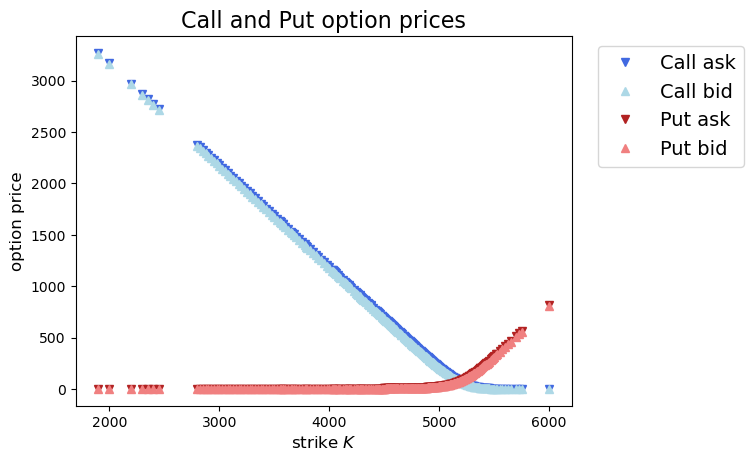

In [6]:
plt.plot(strikes, call_ask, color='royalblue', linewidth=0., marker="v", label="Call ask")
plt.plot(strikes, call_bid, color='lightblue', linewidth=0., marker="^", label="Call bid")

plt.plot(strikes, put_ask, color='firebrick', linewidth=0., marker="v", label="Put ask")
plt.plot(strikes, put_bid, color='lightcoral', linewidth=0., marker="^", label="Put bid")

plt.xlabel("strike $K$", fontsize=12)
plt.ylabel("option price", fontsize=12)
plt.title("Call and Put option prices", fontsize=16)

plt.legend(loc=9, fontsize=14, bbox_to_anchor=(1.2, 1.0), ncol=1)
plt.show()

Let's perform a linear regression so to determine the discount factor and the forward value

We determine the slope $b$ and the intercept $a$ of the linear function that best interpolates the values of $\mathrm{Call}(K) - \mathrm{Put}(K)$:

$$
\mathrm{Call}(K) - \mathrm{Put}(K) \approx f(K) = a + b \, K.
$$

This gives a way of setting the discount factor and the forward for the maturity $T$ we are working with:

$$
D(0,T) = e^{-rT} \quad \text{and} \quad F_0^T = \frac{-a}{b} \quad \text{(in terms of $a$ and $b$)}
$$


In [7]:
import scipy.stats as sps

function linregress of scipy.stats to regress the values of  Call(K) - Put(K) against the strikes 

In [8]:
call_minus_put = call_prices - put_prices

(slope, intercept, rvalue, other_value1, other_value2) = sps.linregress(strikes, call_minus_put)


print("Slope = %1.3f" %slope)
print("Intercept =: %1.2f" %intercept)
print("Correlation coefficient = %1.12f \n" %rvalue)

Slope = -0.994
Intercept =: 5155.95
Correlation coefficient = -0.999999983699 



In [9]:
discount_factor = -slope

F_T = intercept / discount_factor

print("Therefore: \n")
print("D(0,T) = %1.3f" %discount_factor)
print("Forward value F_T = %1.2f" %F_T)

Therefore: 

D(0,T) = 0.994
Forward value F_T = 5184.85


We are now in a good position to evaluate the implied volatility associated with option prices. Recall that the market implied volatility, $\sigma(T,K)$, for a given maturity $T$ and strike price $K$, is the unique solution to the equation:

$$
\text{Call}^{\text{mkt}}(T,K) = \text{Call}_{\text{BS}}(T, K, F_0^T, D(0,T), \sigma(T,K)),
$$

where $\text{Call}_{\text{BS}}(T, K, F, D, \sigma)$ denotes the call price as determined by the Black-Scholes formula for a maturity $T$, a strike price $K$, a forward value $F$, a discount factor $D = e^{-rT}$, and a volatility $\sigma$.

In this framework, the market implied volatility is crucial for capturing the expected fluctuations in the option's underlying asset price over time. It is derived by equating the market-observed call price, $\text{Call}^{\text{mkt}}(T,K)$, with the theoretical call price from the Black-Scholes model, $\text{Call}_{\text{BS}}$, given the existing parameters and the sought-after volatility $\sigma(T,K)$. This calculation offers valuable insights into the market's perceptions and the pricing dynamics of financial derivatives.


In [10]:
from BlackScholesFunctions import Put_BS_core, volImplCore_Newton, volImplPutCore_bisection

Implied vol from puts

In [11]:
vols_puts = np.zeros(strikes.size)

for i in range(strikes.size):
    K = strikes[i]
    
    vol, iterations = volImplCore_Newton(tau = maturity, K = K, DF = discount_factor, F = F_T,
                                            price = put_prices[i], # mid prices for puts
                                            CallOrPutFlag = 0,
                                            initial_point = 0.2, prix_tol = 1.e-4, max_iter=50)
    
    vols_puts[i] = vol


print("Done")

c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  vol = vol - (current_price - price) / Vega_core(tau, K, DF, F, vol)
c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  d_2 = d_1 - sigma_sqrt_tau
c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:73: RuntimeWarning: overflow encountered in scalar power
  vega = DF * F * np.sqrt(tau) * np.exp(-d_1**2 / 2) / np.sqrt(2*np.pi)


Done


Implied vol from calls

In [12]:
vols_calls = np.zeros(strikes.size)

for i in range(strikes.size):
    K = strikes[i]
    
    vol, iterations = volImplCore_Newton(tau = maturity, K = K, DF = discount_factor, F = F_T,
                                            price = call_prices[i], # mid prices for calls
                                            CallOrPutFlag = 1,
                                            initial_point = 0.2, prix_tol = 1.e-4, max_iter=50)
    
    vols_calls[i] = vol

print("Done")

c:\Users\mdale\Desktop\Ecole Polytechnique\Numerical process of financial data\Project_info\BlackScholesFunctions.py:41: RuntimeWarning: invalid value encountered in scalar subtract
  d_2 = d_1 - sigma_sqrt_tau


Done


Let's plot the resulting smile in terms of the log-forward moneyness $k = \log(K / F_0^T)$:

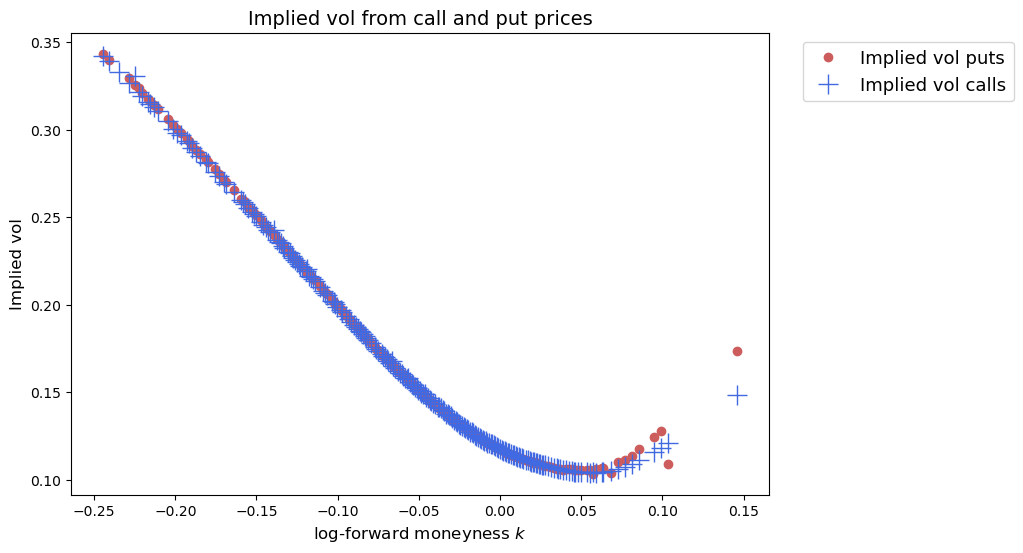

In [13]:
plt.figure(figsize=(9,6))

mkt_log_mon = np.log(strikes/F_T)

plt.plot(mkt_log_mon, vols_puts ,
         color='indianred', linewidth=0., marker=".", markersize=12, label="Implied vol puts")

plt.plot(mkt_log_mon, vols_calls ,
         color='royalblue', linewidth=0., marker="+", markersize=14, label="Implied vol calls")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Implied vol", fontsize=12)
plt.title("Implied vol from call and put prices", fontsize=14)

plt.legend(loc=9, fontsize=13, bbox_to_anchor=(1.2, 1.0), ncol=1)

Let's save all in a file to have the times aligned and to remove the nan values

In [14]:
vol_data = np.array([mkt_log_mon, vols_calls])

valid_mask = ~np.isnan(vol_data).any(axis=0) & ~np.isinf(vol_data).any(axis=0)

filtered_vol_data = vol_data[:, valid_mask]

np.savetxt("SPX_vol_quotes_2.csv", filtered_vol_data, delimiter=";")

In [15]:
quotes_corr = np.loadtxt(open("SPX_vol_quotes_2.csv", "r"), delimiter=";")

print("quotes.shape : ", quotes_corr.shape)

mkt_log_mon = quotes_corr[0]
vols_calls = quotes_corr[1]
    
maturity = 35/365

print("\n Maturity (in years): %1.2f" %maturity)

print("\n Log moneyness: ", mkt_log_mon)
print("Implied vols from calls mid prices: ", vols_calls)

quotes.shape :  (2, 215)

 Maturity (in years): 0.10

 Log moneyness:  [-2.44558893e-01 -2.40871119e-01 -2.34754892e-01 -2.28675846e-01
 -2.25046078e-01 -2.22633532e-01 -2.20226792e-01 -2.16627508e-01
 -2.15430620e-01 -2.13041132e-01 -2.10657341e-01 -2.04722605e-01
 -2.01178597e-01 -1.98822883e-01 -1.96472706e-01 -1.92957764e-01
 -1.91788857e-01 -1.89455133e-01 -1.87126843e-01 -1.84803962e-01
 -1.81329726e-01 -1.80174324e-01 -1.75566021e-01 -1.73269809e-01
 -1.69835346e-01 -1.68693142e-01 -1.64137325e-01 -1.59602170e-01
 -1.58471588e-01 -1.57342282e-01 -1.55087490e-01 -1.52837770e-01
 -1.51714805e-01 -1.50593100e-01 -1.47235514e-01 -1.46118820e-01
 -1.43889164e-01 -1.42776198e-01 -1.41664469e-01 -1.39444713e-01
 -1.37229872e-01 -1.36124289e-01 -1.35019927e-01 -1.33916783e-01
 -1.32814854e-01 -1.30614633e-01 -1.29516335e-01 -1.28419243e-01
 -1.27323352e-01 -1.26228661e-01 -1.25135167e-01 -1.24042868e-01
 -1.22951760e-01 -1.21861842e-01 -1.19685563e-01 -1.18599196e-01
 -1.17514009e-01 -1

Let's use the same procedure used in Notebook 8 part 2 to fit the SVI model to the implied volatility smile

In [16]:
import scipy.optimize as opt

In [17]:
def SVI(k, a, b , rho, k_bar, sig):
    total_variance = a + b * (rho * (k - k_bar) + np.sqrt((k - k_bar)**2 + sig**2))
    
    return total_variance

def SVI_two_arguments(theta, k):
    a, b , rho, k_bar, sig = theta
    
    return SVI(k, a, b , rho, k_bar, sig)

def fct_least_squares(theta, log_mon, tot_implied_variance):
    """
    theta                : the vector of SVI parameters
    log_mon              : log-forward moneyness k (float or double)
    tot_implied_variance : the target total implied variance (float or double)
    
    Returns : the objective function (without the square) to be injected
    in the least-square problem
    """
    return SVI_two_arguments(theta, log_mon) - tot_implied_variance

In [18]:
## Recall that our target is the vector of total variances from (call or put) price quotes
mkt_tot_variance = maturity * vols_calls**2

## Choice of initial point
a_init = np.min(mkt_tot_variance) / 2
b_init = 0.1
rho_init = -0.8
k_bar_init = 0.
sig_init = 0.1

We code the bounds we impose on the SVI parameters

In [19]:
lower = np.array([0.,   # a
                  0.,   # b
                  -1.,  # rho
                  -0.5, # k_bar
                  0.])  # sigma

upper = np.array([np.max(mkt_tot_variance), # a
                  2.,  # b
                  1.,  # rho
                  0.5, # k_bar
                  1.]) # sigma

SVI_param_bounds = (lower, upper)

theta_init = np.array([a_init, b_init, rho_init, k_bar_init, sig_init])

In [20]:
result = opt.least_squares(fun = fct_least_squares ,
                           x0 = theta_init , 
                           bounds = SVI_param_bounds ,
                           args = (mkt_log_mon, mkt_tot_variance), #additional arguments for the LS objective
                           verbose = 1)

## The optimized parameters
a_star, b_star, rho_star, k_bar_star, sig_star = result.x

`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 3.2531e-02, final cost 1.0171e-06, first-order optimality 6.35e-09.


Let's plot the calibrated model

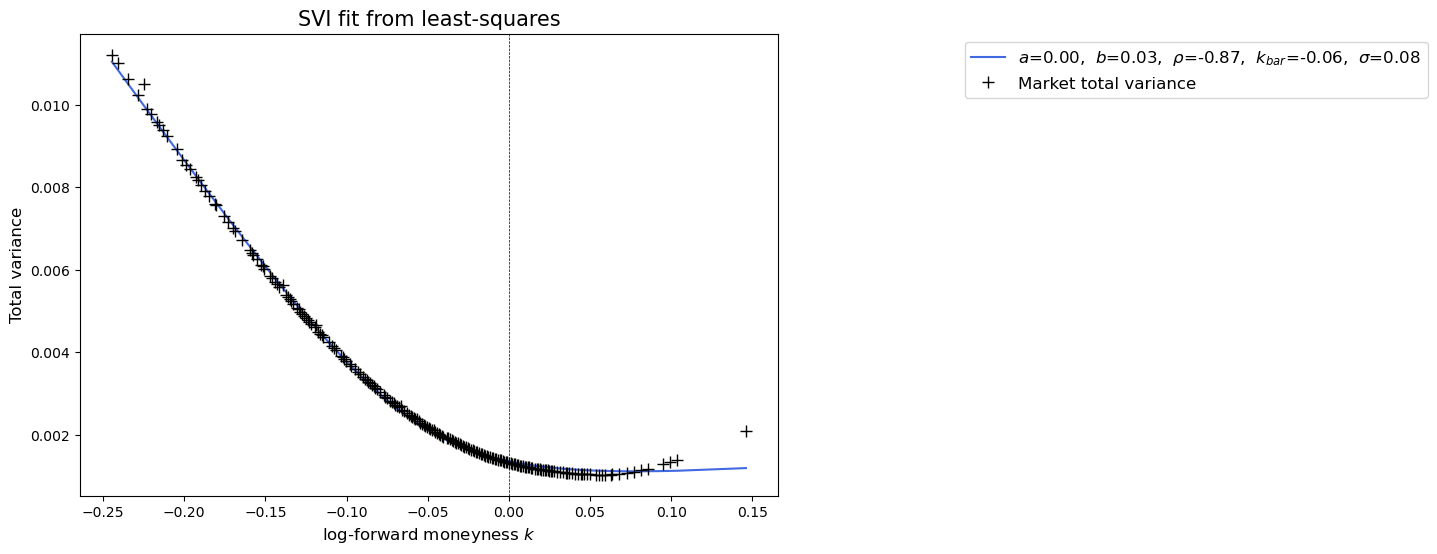

In [21]:
total_variances_fit = SVI(mkt_log_mon , a_star, b_star, rho_star, k_bar_star, sig_star)

plt.figure(figsize=(9,6))

plt.plot(mkt_log_mon, total_variances_fit,
         color='royalblue', linewidth=1.5, 
         label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $k_{bar}$=%1.2f,  $\sigma$=%1.2f" %(a_star, b_star, rho_star, k_bar_star, sig_star))

plt.plot(mkt_log_mon, mkt_tot_variance,
         color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")


plt.axvline(0., linestyle="--", linewidth=0.5, color="k")

plt.xlabel(r"log-forward moneyness $k$", fontsize=12)
plt.ylabel("Total variance", fontsize=12)
plt.title(r"SVI fit from least-squares", fontsize=15)

plt.legend(loc=9, fontsize=12, bbox_to_anchor=(1.6, 1.0), ncol=1)

$\blacktriangleright$ Try to take into account the no-arbitrage conditions within the parameter learning process (or at least, after the learning process).

Explain in details the procedure you have followed, and present/discuss your results.

Let's take into account the no-arbitrage conditions seen in Notebook 9 to see if the set of parameters we have found satisfy them

1. **Test positivity**

In [22]:
def test_positivity(a, b, rho, sig):
    assert(rho <= 1); assert(-1 <= rho)
    assert(b > 0)
    
    ## We check the positivity of the minimum 
    minimum = a + b * sig * np.sqrt(1 - rho ** 2)
    assert(minimum > 0)
    
    print("\n Positivity test: OK \n")
    
    return 0

In [23]:
test_positivity(a_star, b_star, rho_star, sig_star)


 Positivity test: OK 



0

2. **Convexity Condition**

In [24]:
def test_convexity(k, a, b, rho, k_bar, sig):
    square_rt = np.sqrt( (k - k_bar)*(k - k_bar) + sig*sig)
    
    w = SVI(k, a, b, rho, k_bar, sig)
    
    first_der_w = b*rho + b*(k - k_bar) / square_rt
    
    second_der_w = b*sig*sig / (square_rt**3)
    
    g = 0.5 * second_der_w + (1 - (k * first_der_w) / (2 * w) )**2 - 0.25 * (1 / w + 0.25) * (first_der_w**2)
    
    return g


def numerical_test_convexity(a, b, rho, k_bar, sig, log_mon_lower=-1, log_mon_upper=1):
    log_moneyness_test = np.linspace(log_mon_lower, log_mon_upper, 500)

    test_fct_g = np.array([test_convexity(k, a, b, rho, k_bar, sig) for k in log_moneyness_test])

    plt.figure(figsize=(9,6))

    plt.plot( log_moneyness_test, test_fct_g , color="red", linewidth=0., marker=".", markersize=4, \
             label=r"$a$=%1.2f,  $b$=%1.2f,  $\rho$=%1.2f,  $\bar{k}$=%1.2f,  $\sigma$=%1.2f" %(a,b,rho,k_bar,sig))

    plt.axhline(0., linestyle="--", color="k")

    plt.xlabel("log-forward moneyness $k$", fontsize=14)
    plt.ylabel("Function g(k) in Condition 1", fontsize=14)
    plt.title(r"Test of butterfly arbitrage for SVI parameterisation", fontsize=18)

    plt.legend(loc=9, fontsize=14, bbox_to_anchor=(1.4, 1.0), ncol=1)

    plt.show()
    
    assert( (test_fct_g >= 0).all )
    
    pass

Let's plot and check the positivity of $g_{\mathrm{SVI}}(k)$ for the calibrated SVI parameters.

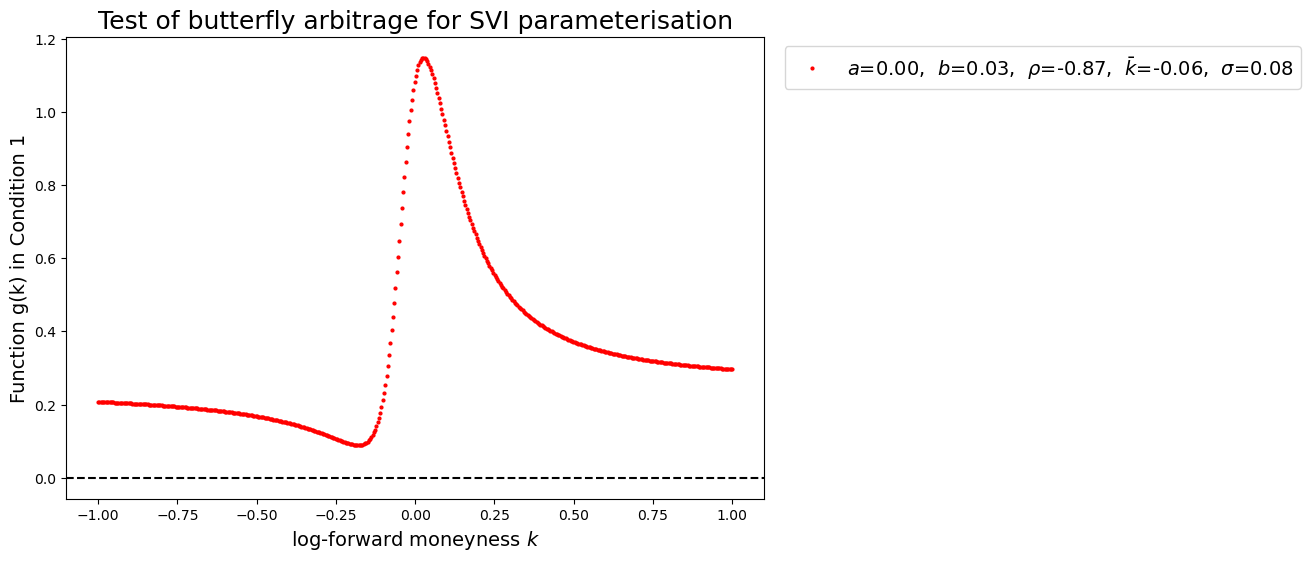

In [25]:
numerical_test_convexity(a_star, b_star, rho_star, k_bar_star, sig_star)

In [26]:
k_range = np.linspace(-1, 1, 500)

g_SVI_values = np.array([test_convexity(k, a_star, b_star, rho_star, k_bar_star, sig_star) for k in k_range])

convexity_check = np.all(g_SVI_values >= 0)

print("Convexity check for the SVI fit: ", convexity_check)

print("Minimum value of g_SVI(k) : ", g_SVI_values.min())

Convexity check for the SVI fit:  True
Minimum value of g_SVI(k) :  0.08909136158584186


3. **Limit/Slope Condition**

In [27]:
print(f"No-butterfly arbitrage slope condition met: {b_star * (1 + rho_star) < 2} \n")

No-butterfly arbitrage slope condition met: True 



## Part 2. The SSVI ("surface SVI") sub-family

Below, you will recognize the SSVI parametric model that was presented in Notebook 9.

The SSVI parameterisation of [Gatheral and Jacquier, 2014](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323) is constructed as follows: first define the

### SSVI slice

$$
w_\mathrm{SSVI}(k) = \frac{\theta} 2 \Bigl(1 + \varphi \, \rho k + \sqrt{(\varphi \, k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R
$$

where 

$$
\theta \ge 0, \qquad \varphi \ge 0, \qquad \rho \in (-1,1).
$$

Note that $w_\mathrm{SSVI}(k) \big|_{k=0} = \theta$, so that the parameter $\theta$ corresponds to the ATM total variance.

+ Thanks to the reduced complexity (3 parameters instead of 5), the no-butterfly arbitrage conditions 1) and 3) from the lecture notes on a SSVI slice can be replaced with much simpler conditions on the parameters $(\theta, \varphi, \rho)$, given in [Gatheral and Jacquier 2014], Theorem 4.2, which states that the no-arbitrage conditions 1) and 3) are satisfied if

$$
\left\{
\begin{aligned}
&\theta \, \varphi \, (1+|\rho|) < 4
\\
&\theta \, \varphi^2 \, (1+|\rho|) \le 4.
\end{aligned}
\right.
$$

$\blacktriangleright$ __TO DO__: perform a fitting of the SSVI slice parameters (as opposed to SVI) to the market data already used in Part 1.2 (for the same fixed maturity).

Take into account the no-arbitrage conditions on the SSVI parameterisation within or after the parameter learning process. Explain in details the procedure you have followed, and present/discuss your results.

In [28]:
from scipy.optimize import minimize

Define the same functions in notebook 9

In [29]:
def ssvi_slice(k, theta, phi, rho):
    """
    Computes the SSVI implied total variance for a given log-moneyness.

    Parameters:
    - k (float or np.array): Log-moneyness, defined as log(K/F), where K is the strike price and F is the forward price.
    - theta (float): Parameter representing the at-the-money (ATM) total variance of the option for a given maturity.
    - phi (float): Parameter controlling the skewness and curvature of the volatility smile.
    - rho (float): Correlation parameter between the underlying asset returns and volatility, controlling the skew of the smile.

    Returns:
    - float or np.array: The implied total variance according to the SSVI parameterization for the given log-moneyness.
    """
    return (theta / 2) * (1 + phi * rho * k + np.sqrt((phi * k + rho)**2 + 1 - rho**2))


def objective(params, k, tot_implied_variance):
    """
    Objective function for the SSVI calibration process. Calculates the sum of squared errors (SSE) 
    between the market implied volatilities and the volatilities predicted by the SSVI model 
    given a set of parameters. Includes safeguards against invalid parameter values.

    Parameters:
    - params (list or np.array): An array containing the SSVI parameters to be optimized:
        - theta (float): Represents the at-the-money (ATM) total variance for a given maturity.
        - phi (float): Controls the skewness and curvature of the volatility smile.
        - rho (float): Correlation parameter, controlling the skew of the smile.
    - k (np.array): An array of log-moneyness values. Log-moneyness is defined as log(K/F),
      where K is the strike price and F is the forward price of the underlying asset.
    - market_vols (np.array): An array of observed market implied volatilities corresponding
      to each log-moneyness value in `k`.
    - maturity (float): The maturity of the options in years.

    Returns:
    - error (float): The sum of squared errors between the market implied volatilities and the 
      volatilities predicted by the SSVI model. Returns a large penalty value if the 
      parameters are out of their valid range or if the computation results in NaN.
      
    Notes:
    - The function incorporates safeguards to return a high penalty value if the parameters
      are outside their valid range (e.g., negative theta or phi, or abs(rho) >= 1) or if the
      computed error is NaN. This helps guide the optimization process away from invalid
      parameter regions.
    """
    theta, phi, rho = params
    
    if theta <= 0 or phi < 0 or abs(rho) >= 1:
        return 1e6
    
    error = np.sum((tot_implied_variance - ssvi_slice(k, theta, phi, rho))**2)
    
    if np.isnan(error):
        return 1e6
    
    return error

We put the no arbitrage conditions in the constraints of the optimization problem:

$$
\left\{
\begin{aligned}
&\theta \, \varphi \, (1+|\rho|) < 4
\\
&\theta \, \varphi^2 \, (1+|\rho|) \le 4.
\end{aligned}
\right.
$$

In [30]:
constraints = (
    {'type': 'ineq', 'fun': lambda x: 4 - x[0] * x[1] * (1 + abs(x[2]))},
    {'type': 'ineq', 'fun': lambda x: 4 - x[0] * x[1]**2 * (1 + abs(x[2]))}
)

initial_guess = np.array([0.01, 0.01, -0.05])

In [31]:
result = minimize(objective, initial_guess, args=(mkt_log_mon, mkt_tot_variance),
                  method='COBYLA')

if result.success:
    calibrated_theta, calibrated_phi, calibrated_rho = result.x
    print(f"Calibrated parameters: theta={calibrated_theta}, phi={calibrated_phi}, rho={calibrated_rho}")
else:
    print("Calibration failed:", result.message)

Calibrated parameters: theta=0.003331941597588411, phi=0.58172099054161, rho=0.9595239835123076


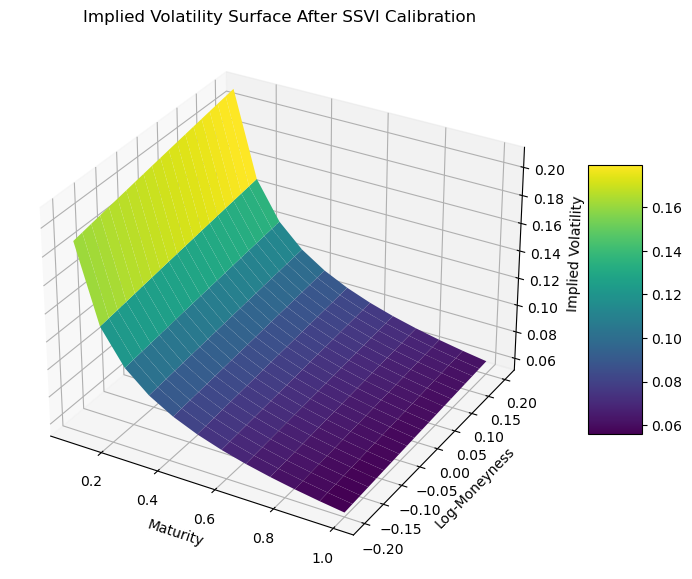

In [33]:
### NOOOOOOO


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming mkt_log_mon and maturity represent your ranges of log-moneyness and maturities respectively
# You might need to define these ranges based on your dataset or analysis requirements

# Example ranges (you should adjust these based on your actual data and requirements)
log_moneyness_range = np.linspace(-0.2, 0.2, 20)  # Example log-moneyness range
maturity_range = np.linspace(1/12, 1, 12)  # Example maturities from 1 month to 1 year

# Use your calibrated parameters here
calibrated_theta, calibrated_phi, calibrated_rho = result.x  # Adjusted as per your calibration results

# Function to compute implied volatility surface using ssvi_slice
def calculate_iv_surface(log_moneyness_range, maturity_range, theta, phi, rho):
    iv_surface = np.zeros((len(maturity_range), len(log_moneyness_range)))
    for i, T in enumerate(maturity_range):
        for j, k in enumerate(log_moneyness_range):
            iv_surface[i, j] = np.sqrt(ssvi_slice(k, theta, phi, rho) / T)
    return iv_surface

# Compute the implied volatility surface
iv_surface = calculate_iv_surface(log_moneyness_range, maturity_range, calibrated_theta, calibrated_phi, calibrated_rho)

# Prepare meshgrid for 3D plotting
T, K = np.meshgrid(maturity_range, log_moneyness_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(T, K, iv_surface.T, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Maturity')
ax.set_ylabel('Log-Moneyness')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface After SSVI Calibration')

# Show color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
### NOOOOOOO


# Plot optimized SSVI surface

total_variances_df_star = SSVI_surface(maturity_list, log_forward_k, rho_star, lambda_star)

import plotly.graph_objects as go

# Prepare data for plotting
x = total_variances_df_star.index.astype(float)  # Your k values
y = total_variances_df_star.columns.astype(float)  # Your maturity values
z = total_variances_df_star.values  # The total variance values

# Create meshgrid for plotting
X, Y = np.meshgrid(x, y)
Z = z

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])

# Add the initial guess curve (assuming it's a line at maturity 36)
fig.add_trace(go.Scatter3D(x=log_forward_k, y=[T[1]]len(log_forward_k), z=T*1*vols_calls_1*2,
                           mode='lines', name='Initial SSVI guess (36 days)',
                           line=dict(color='royalblue', width=2)))

# Add the market total variance curve (assuming it's a line at maturity 64)
fig.add_trace(go.Scatter3D(x=log_forward_k, y=[T[2]]len(log_forward_k), z=T*2*vols_calls_2*2,
                           mode='lines', name='Market total variance (64 days)',
                           line=dict(color='black', width=2)))

# Set plot titles and labels
fig.update_layout(title='SSVI Total Variance Surface', autosize=False,
                  width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
                      xaxis_title='Strike (k)',
                      yaxis_title='Maturity',
                      zaxis_title='Total Variance'
                  ))

# Show the plot
fig.show()

### Full SSVI surface

So far, we have only worked with fixed-maturity slices of the implied volatility surface. We haven't defined a function $w_\mathrm{SSVI}$ of $(T, k)$ yet.

Given:

+ a curve $T \mapsto \theta_T \ge 0$ (representing at-the-money total implied variance for maturity $T$)


+ a function $\varphi: \mathbb R_+ \to \mathbb R_+$,

the full __Surface SVI__ model is defined by

$$
\begin{aligned}
w_\mathrm{SSVI}(T, k) 
&= 
w_\mathrm{SSVI}(k; \ \theta_{T}, \ \varphi(\theta_T), \ \rho) 
\\
&= \frac{\theta_{T}} 2 \Bigl(1 + \varphi(\theta_{T}) \rho k + \sqrt{\bigl(\varphi(\theta_{T}\bigr) k + \rho)^2 + 1 - \rho^2} \Bigr),
\qquad k \in \mathbb R, T > 0.
\end{aligned}
$$

The no-calendar spread arbitrage condition we have seen in the lectures:
  
2) The function $T \mapsto w_\mathrm{SSVI}(T, k) $ is increasing, for every $k \in \mathbb R$,

can also be reformulated as a simple condition on the functions $\theta_\cdot$ and $\varphi(\cdot)$, see [Gatheral and Jacquier 2014], Theorem 4.1:

$$
\left\{
\begin{aligned}
& T \mapsto \theta_T \text{ is increasing,} \\
& 0 \le \frac{\partial}{\partial \theta} (\theta \varphi(\theta)) \le \frac{1}{\rho^2} \left(1+ \sqrt{1-\rho^2}\right) \varphi(\theta) \quad \forall \theta,
\end{aligned}
\right.
$$

where, in the second line, we have supposed that the functions $\theta_\cdot$ and $\varphi(\cdot)$ are differentiable.

[Gatheral and Jacquier 2014] provide parametric examples of functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ that satisfy the no-calendar spread arbitrage condition above.

$\blacktriangleright$ __TO DO__: dowload and use option data for at least two different maturities $T_1$ and $T_2$ (or more if you wish), observed at the same date $t$. Make a parametric choice for the functions $T \mapsto \theta_T$ and $\theta \mapsto \varphi(\theta)$ and perform a fitting of the full SSVI surface model to your target maturities.

Take into account the no-arbitrage conditions on SSVI within or after the parameter learning process. Explain in details the procedure you have followed, and present/discuss your results.

Download a dataset with 2 maturities

### Implementation of SSVI Parameterization Functions

To model the implied volatility surface, we implement a set of functions based on the Heston-like parameterization. These functions will allow us to construct the full Surface Stochastic Volatility Inspired (SSVI) model.

#### The $\varphi(\theta)$ Function

The function $\varphi(\theta)$ is defined according to a Heston-like parameterization as follows:

$$
\varphi(\theta) \equiv \frac{1}{\lambda \theta}\left\{1-\frac{1-\mathrm{e}^{-\lambda \theta}}{\lambda \theta}\right\}
$$

### SSVI Model Calibration with Heston-Like Parametrization

In this section, we will outline the process of calibrating the Stochastic Volatility Inspired (SSVI) model for the implied volatility surface. The calibration will be based on the Heston-like parametrization for the skewness function $\varphi(\theta)$. We'll define the necessary functions and describe the fitting procedure to align our model with the market data for different maturities.

#### Defining the Skewness Function

The skewness function $\varphi(\theta)$, inspired by the Heston model for stochastic volatility, is specified as:

$$
\varphi(\theta) = \frac{1}{\lambda} \left( 1 - \frac{1 - e^{-\lambda \theta}}{\lambda \theta} \right),
$$

where $\lambda$ is a parameter that controls the rate at which skewness decays as a function of the at-the-money (ATM) total implied variance $\theta$.

In [34]:
import numpy as np

def varphi(theta, lambd):
 
    return (1 / lambd) * (1 - (1 - np.exp(-lambd * theta)) / (lambd * theta))


def theta_T(T, a, b):

    return a + b * T

def ssvi_surface(T, k, theta, lambd, rho):
    
    varphi_val = varphi(theta, lambd)
    
    return (theta / 2) * (1 + varphi_val * rho * k + np.sqrt((varphi_val * k + rho)**2 + 1 - rho**2))